In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
#jtplot.style()
jtplot.reset()

In [109]:
### lists and dicts to help clear dataframes
#list of columns i want to keep
const_cols = ["Province/State", "Country", "Country/Region", "Date last updated", "Last Update", "Confirmed", "Recovered", "Deaths"]
#dict of column names to change
column_names = {"Country": "Country/Region", "Date last updated": "Last Update"}
#dict of columns and values to put in NaNs
fillna_values = {'Province/State': "", "Country/Region": "", "Confirmed": 0, "Recovered": 0, "Deaths":0}

In [110]:
def read_time_series_csv(url, save, file_name):
    
    df_ts = pd.read_csv(url)
    
    #df_ts = df_ts.dropna(axis=0, how='all')
    #df_ts = df_ts.dropna(axis=1, how='all')

    df_text = df_ts[df_ts.columns[0:2]]
    df_text = df_text.fillna(value = '')
    
    df_val = df_ts[df_ts.columns[2:len(df_ts.columns)]]
    df_val = df_val.fillna(value = 0)
    
    df_ts = pd.concat([df_text,df_val],axis=1)
    
    if save == True:
        writer = pd.ExcelWriter(file_name, engine='xlsxwriter')

        df_ts.to_excel(writer, index=False)

        writer.save()

    return df_ts

In [111]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

In [112]:
df_confirmed = read_time_series_csv(url_confirmed, True, "COVID19-Confirmed.xlsx")
df_deaths = read_time_series_csv(url_deaths, True, "COVID19-Deaths.xlsx")
df_recovered = read_time_series_csv(url_recovered, True, "COVID19-Recovered.xlsx")

In [113]:
print(df_confirmed)

                  Province/State        Country/Region       Lat       Long  \
0                          Anhui        Mainland China  31.82571  117.22640   
1                        Beijing        Mainland China  40.18238  116.41420   
2                      Chongqing        Mainland China  30.05718  107.87400   
3                         Fujian        Mainland China  26.07783  117.98950   
4                          Gansu        Mainland China  36.06110  103.83430   
5                      Guangdong        Mainland China  23.33841  113.42200   
6                        Guangxi        Mainland China  23.82908  108.78810   
7                        Guizhou        Mainland China  26.81536  106.87480   
8                         Hainan        Mainland China  19.19673  109.74550   
9                          Hebei        Mainland China  38.04280  114.51490   
10                  Heilongjiang        Mainland China  47.86200  127.76220   
11                         Henan        Mainland Chi

In [114]:
print("Shape of df_confirmed: {}".format(df_confirmed.shape))
print("Shape of df_deaths: {}".format(df_deaths.shape))
print("Shape of df_recovered: {}".format(df_recovered.shape))

#printing whole df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(df_confirmed)

Shape of df_confirmed: (75, 29)
Shape of df_deaths: (75, 29)
Shape of df_recovered: (75, 29)


In [115]:
china_confirmed = df_confirmed[df_confirmed['Country/Region']=="Mainland China"].iloc[:,4:].sum(axis=0)
china_deaths = df_deaths[df_deaths['Country/Region']=="Mainland China"].iloc[:,4:].sum(axis=0)
china_recovered = df_recovered[df_recovered['Country/Region']=="Mainland China"].iloc[:,4:].sum(axis=0)

print(china_confirmed)
#print(china_recovered_series)
#print(china_deaths_series)

1/22/20      547
1/23/20      639
1/24/20      916
1/25/20     1399
1/26/20     2062
1/27/20     2863
1/28/20     5494
1/29/20     6070
1/30/20     8124
1/31/20     9783
2/1/20     11871
2/2/20     16607
2/3/20     19693
2/4/20     23680
2/5/20     27409
2/6/20     30553
2/7/20     34075
2/8/20     36778
2/9/20     39790
2/10/20    42306
2/11/20    44327
2/12/20    44699
2/13/20    59832
2/14/20    66292
2/15/20    68347
dtype: int64


In [116]:
dates_confirmed = china_confirmed.index.values
dates_deaths = china_deaths.index.values
dates_recovered = china_recovered.index.values

print(dates_confirmed)
#print(dates_1)
#print(dates_2)

dates_datetime_confirmed = pd.to_datetime(dates_confirmed, infer_datetime_format=True)
dates_datetime_deaths = pd.to_datetime(dates_deaths, infer_datetime_format=True)
dates_datetime_recovered = pd.to_datetime(dates_recovered, infer_datetime_format=True)

print(dates_datetime_confirmed)


['1/22/20' '1/23/20' '1/24/20' '1/25/20' '1/26/20' '1/27/20' '1/28/20'
 '1/29/20' '1/30/20' '1/31/20' '2/1/20' '2/2/20' '2/3/20' '2/4/20'
 '2/5/20' '2/6/20' '2/7/20' '2/8/20' '2/9/20' '2/10/20' '2/11/20'
 '2/12/20' '2/13/20' '2/14/20' '2/15/20']
DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15'],
              dtype='datetime64[ns]', freq=None)


In [117]:
#something for converting datetime for x axis
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

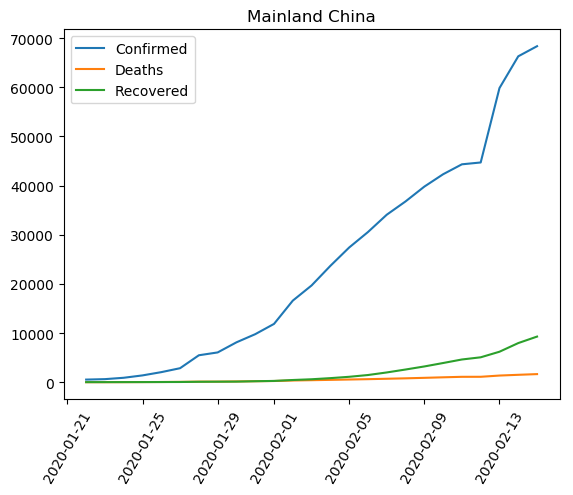

In [118]:
plt.plot(dates_datetime_confirmed, china_confirmed, dates_datetime_deaths, china_deaths, dates_datetime_recovered, china_recovered)
plt.xticks(rotation=60)
plt.legend(['Confirmed', 'Deaths', 'Recovered'])
plt.title("Mainland China")
plt.savefig("img/china.png",bbox_inches='tight')

In [119]:
countries_ts = df_confirmed['Country/Region'].unique()
print(len(countries_ts))
print(countries_ts)

30
['Mainland China' 'Thailand' 'Japan' 'South Korea' 'Taiwan' 'US' 'Macau'
 'Hong Kong' 'Singapore' 'Vietnam' 'France' 'Nepal' 'Malaysia' 'Canada'
 'Australia' 'Cambodia' 'Sri Lanka' 'Germany' 'Finland'
 'United Arab Emirates' 'Philippines' 'India' 'Italy' 'UK' 'Russia'
 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt']


In [120]:
#for country in countries_ts:
    #plt.plot(dates_datetime, ts_df_list[0][ts_df_list[0]['Country/Region']==country].iloc[:,5:].sum(axis=0))
    #plt.show()

In [121]:
#math for using floor
import math

8


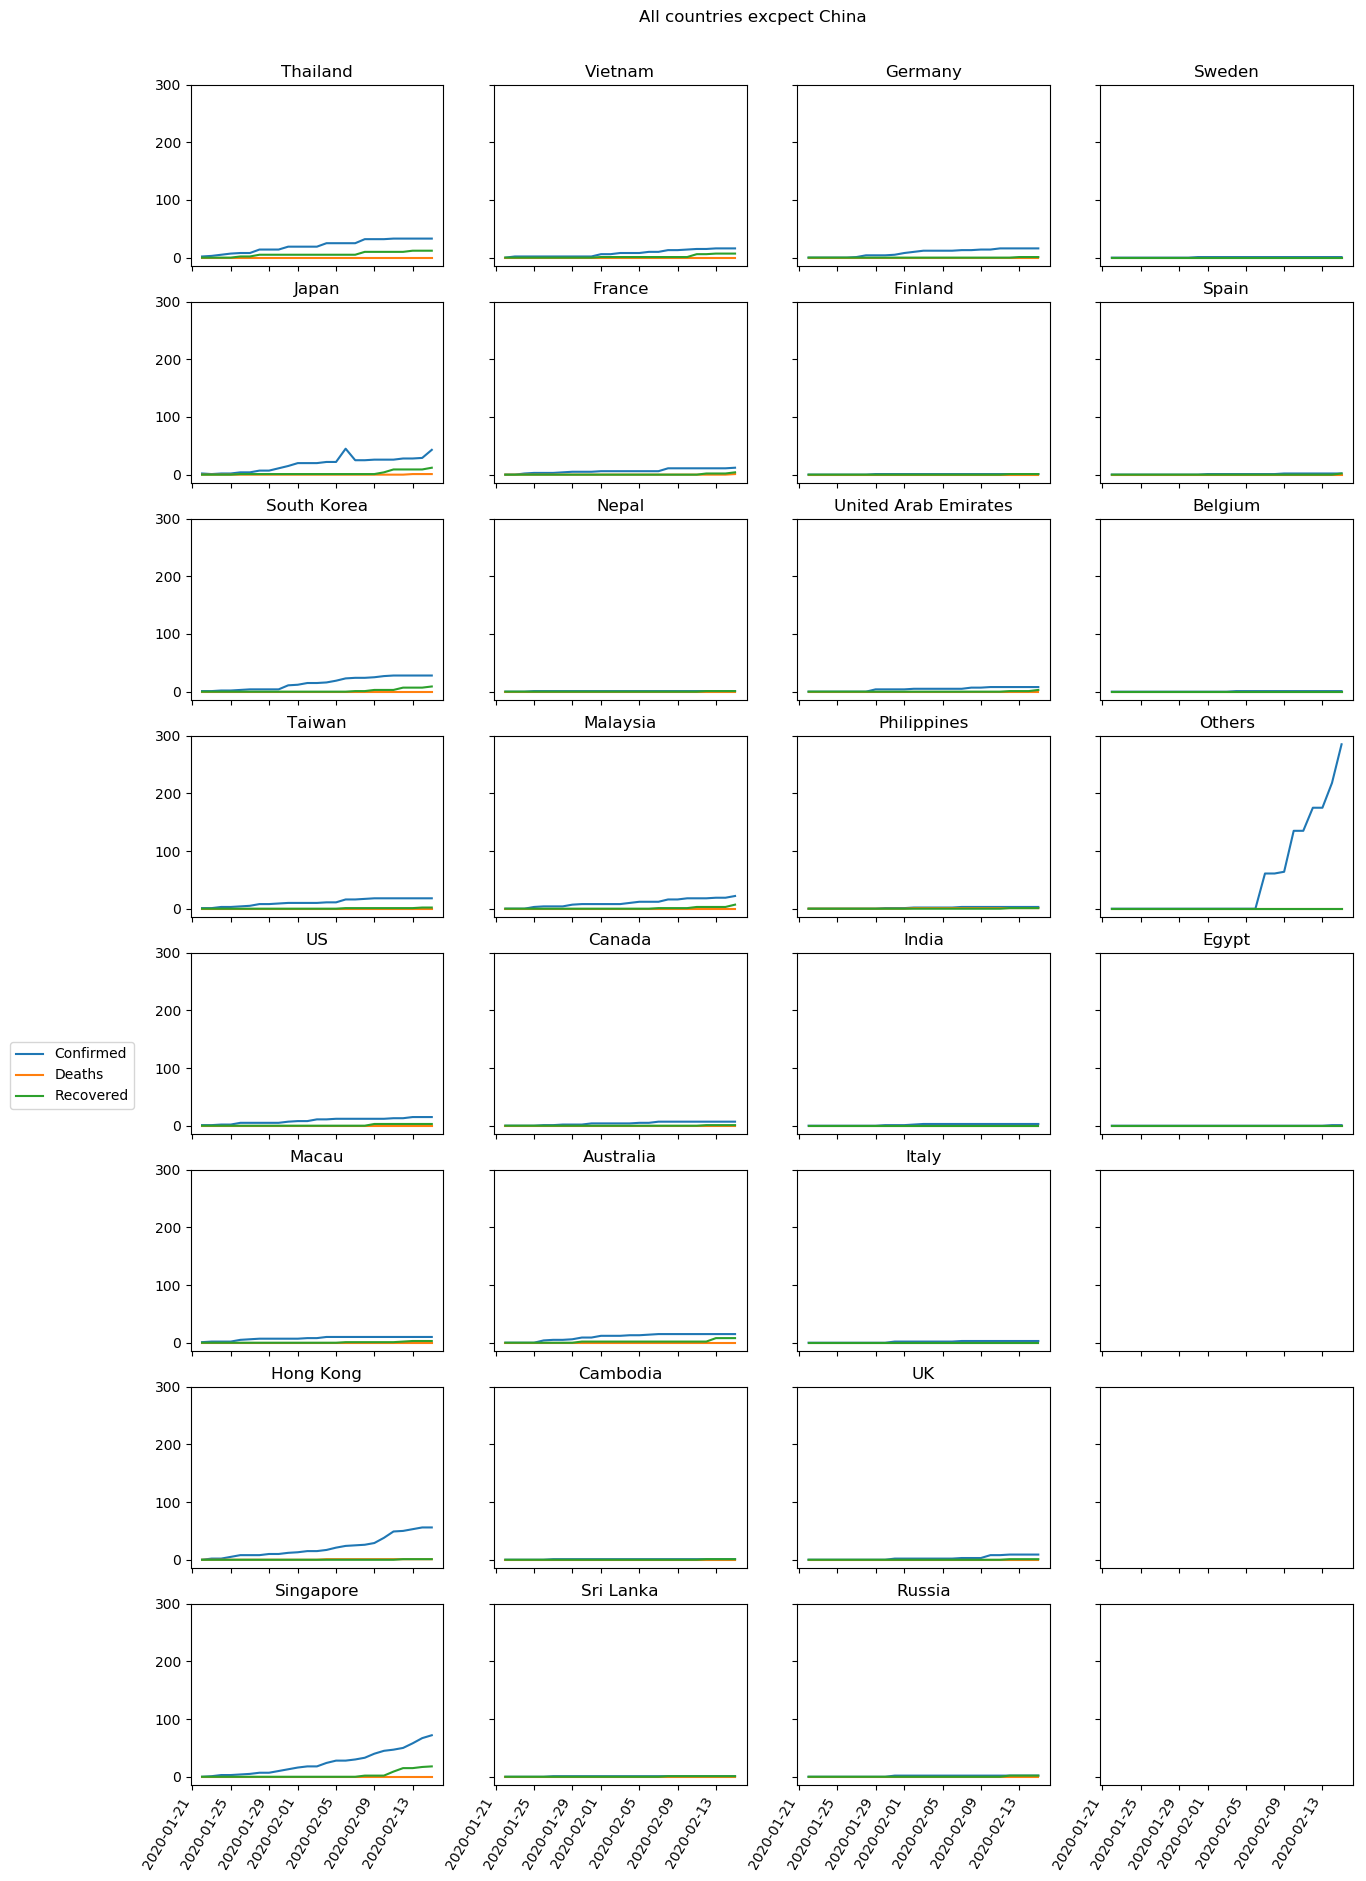

In [122]:
#country_confirmed = df_confirmed[df_confirmed['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
#dates_confirmed = country_confirmed.index.values
#dates_datetime_confirmed = pd.to_datetime(dates_confirmed, infer_datetime_format=True)

#country_deaths = df_deaths[df_deaths['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
#dates_deaths = country_deaths.index.values
#dates_datetime_deaths = pd.to_datetime(dates_deaths, infer_datetime_format=True)

#country_recovered = df_recovered[df_recovered['Country/Region']==countries_ts[0]].iloc[:,5:].sum(axis=0)
#dates_recovered = country_recovered.index.values
#dates_datetime_recovered = pd.to_datetime(dates_recovered, infer_datetime_format=True)
    
plots_in_row = 4
#define how many rows on how many countries in list without china
plots_in_col = math.ceil((len(countries_ts)-1)/plots_in_row)

print(plots_in_col)

fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, 25), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_ts[1:]:
    
    axs[i][j].plot(dates_datetime_confirmed,df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_deaths,df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_recovered,df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('All countries excpect China',y=0.91)
fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0., 0., 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
plt.savefig("img/rest.png",bbox_inches='tight')

In [123]:
#list of number of confirmed cases from last column
confirmed_country = []
row = len(dates_confirmed)-1
for country in countries_ts:
    confirmed_country.append(df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0)[row])

print(confirmed_country)

[68347, 33, 43, 28, 18, 15, 10, 56, 72, 16, 12, 1, 22, 7, 15, 1, 1, 16, 1, 8, 3, 3, 3, 9, 2, 1, 2, 1, 285, 1]


In [124]:
limit = 19

In [125]:
dictionary = {"Country":countries_ts ,"Confirmed":confirmed_country}

countries_last_date = pd.DataFrame(dictionary)
# print(countries_last_date)

if_over_limit = countries_last_date.apply(lambda x: True if x['Confirmed'] > limit else False , axis=1)

numOfRows = len(if_over_limit[if_over_limit == True].index)
 
print('Number of countries with over {} confirmed cases: {}'.format(limit,numOfRows))

Number of countries with over 19 confirmed cases: 8


In [126]:
#
indexTrue = if_over_limit[ if_over_limit == False ].index
indexFalse = if_over_limit[ if_over_limit == True ].index
print(indexTrue)
print(indexFalse)

#copying to not change original df
countries_over_limit = countries_last_date.copy()
countries_under_limit = countries_last_date.copy()

countries_over_limit.drop(indexTrue, inplace=True, axis=0)
countries_under_limit.drop(indexFalse, inplace=True, axis=0)

#print(countries_over_limit)
#print(countries_under_limit)

Int64Index([ 4,  5,  6,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
            24, 25, 26, 27, 29],
           dtype='int64')
Int64Index([0, 1, 2, 3, 7, 8, 12, 28], dtype='int64')


In [127]:
#print(countries_last_date)

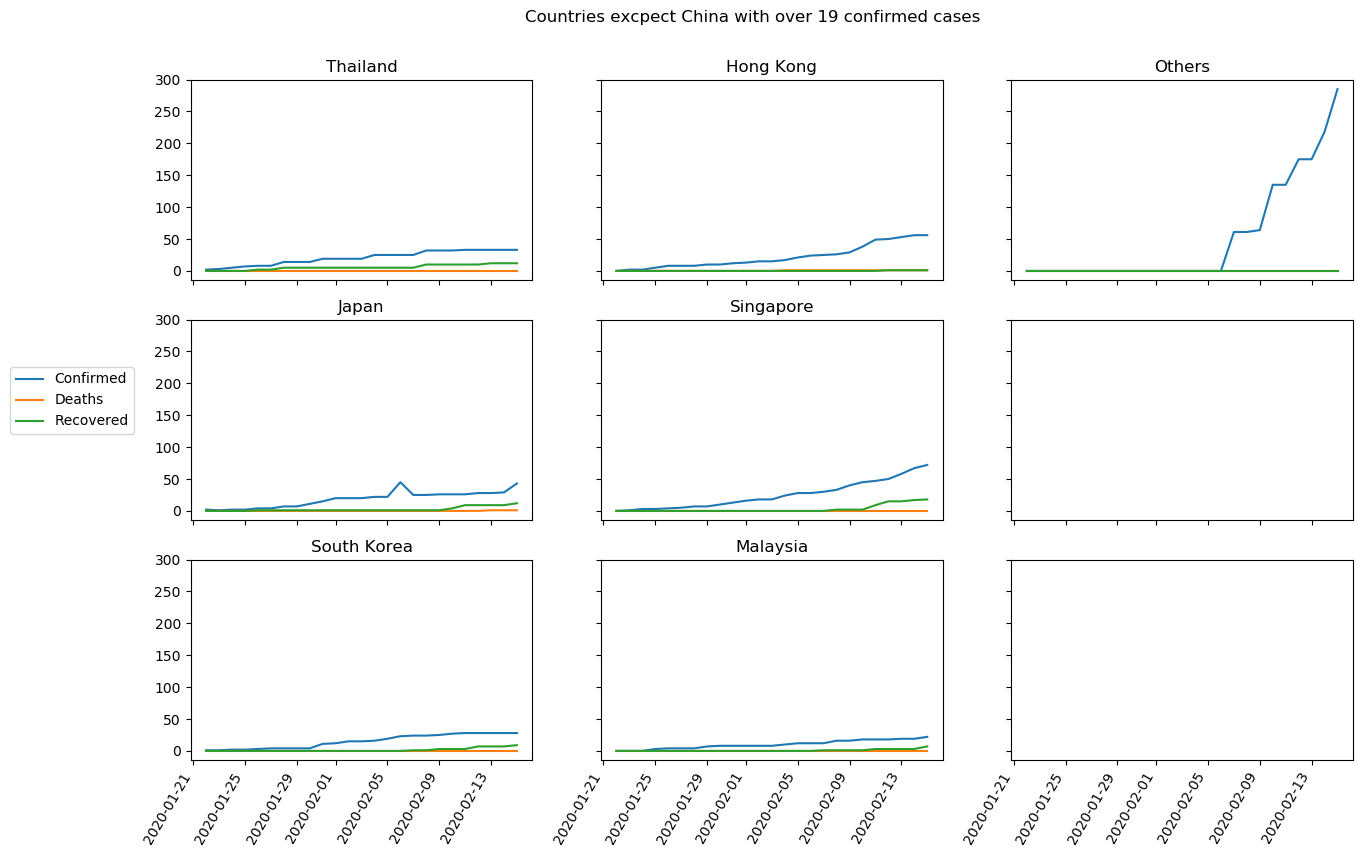

In [128]:
###plot for countries with confirmed cases over limit
plots_in_row = 3
#define how many rows on how many countries in list without china
plots_in_col = math.ceil((numOfRows-1)/plots_in_row)

fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, 10), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_over_limit["Country"][1:]:
    #print(country)
    axs[i][j].plot(dates_datetime_confirmed, df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_deaths, df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_recovered, df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('Countries excpect China with over {} confirmed cases'.format(limit),y=0.95)
fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0., 0.1, 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
plt.savefig("img/rest_over_limit.png",bbox_inches='tight')

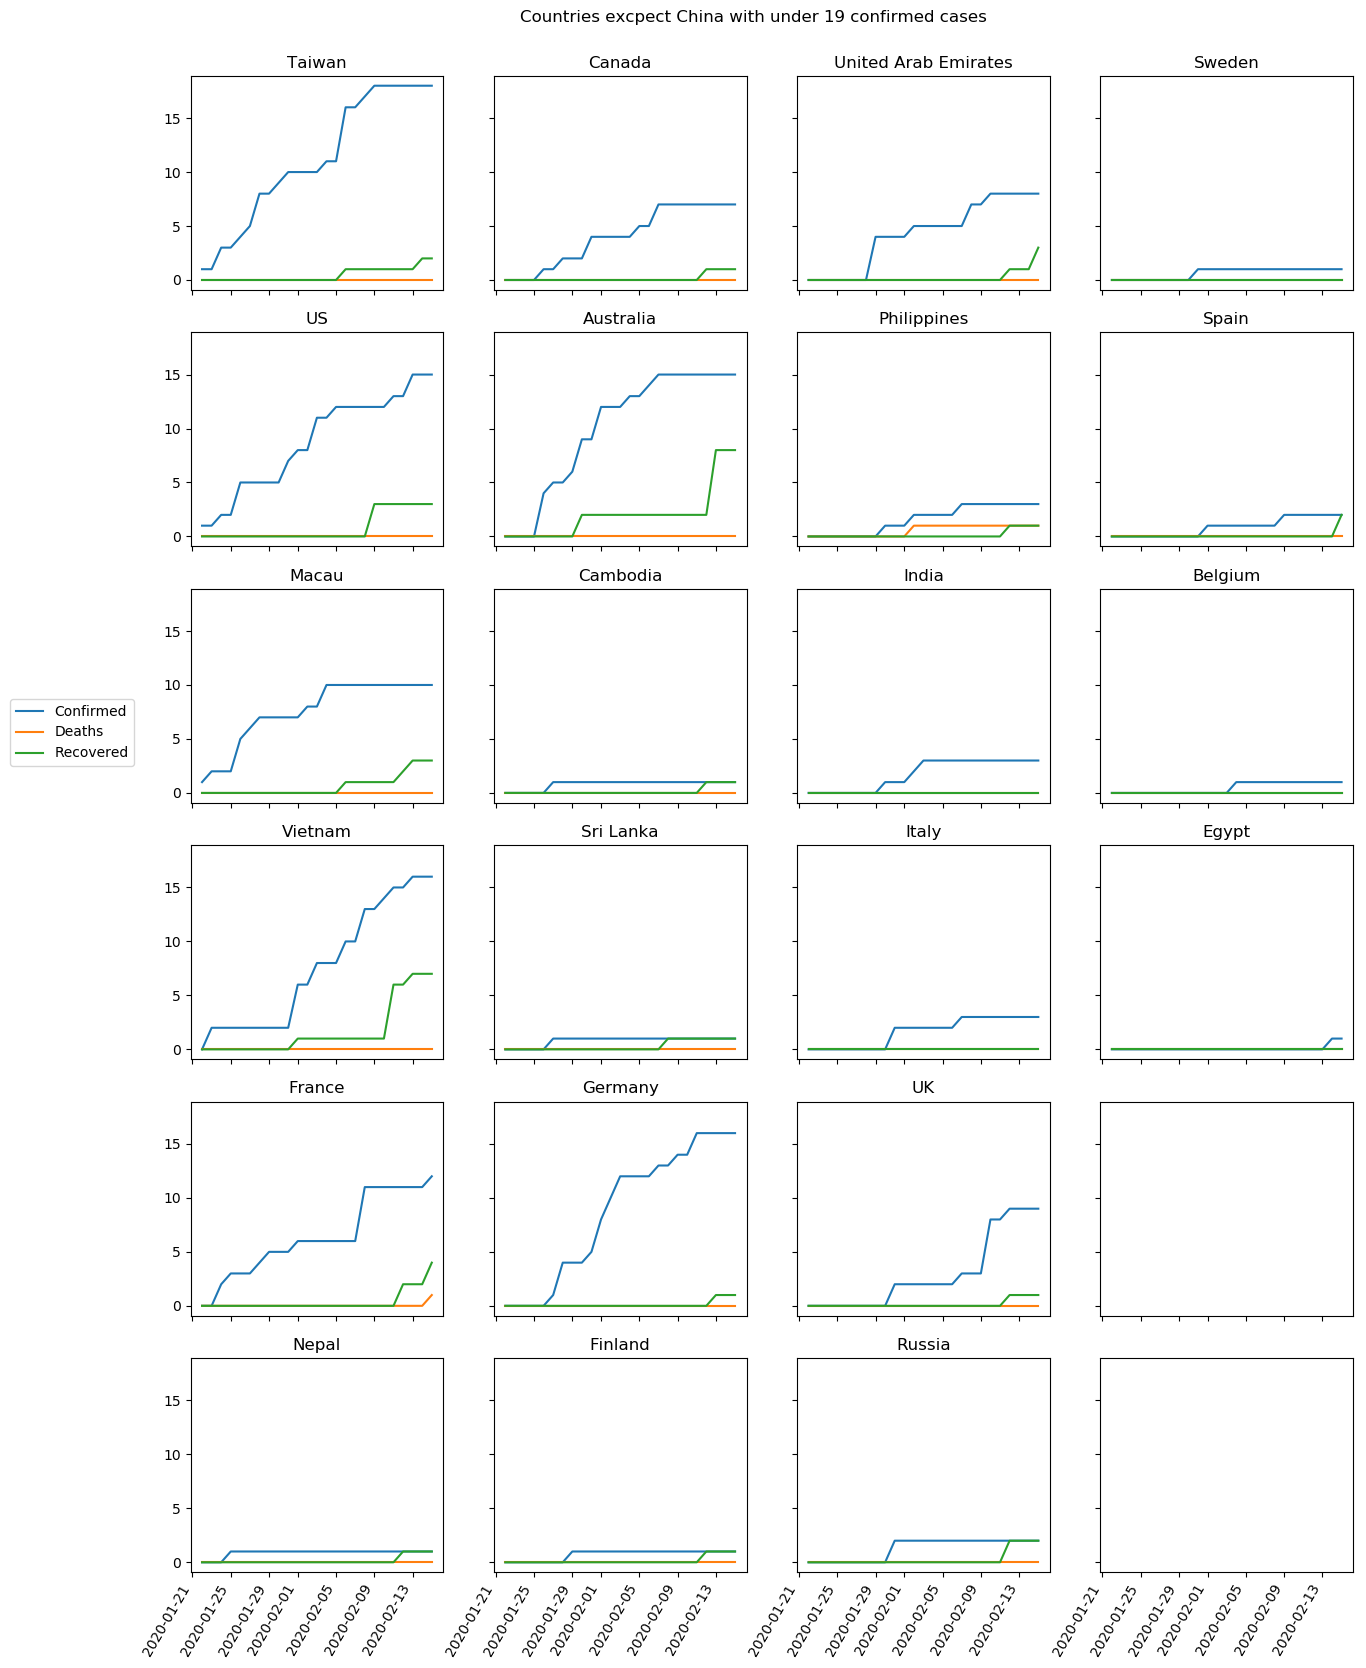

In [129]:
###plot for countries with confirmed cases over limit
plots_in_row = 4
#define how many rows on how many countries in list without china
plots_in_col = math.ceil((len(countries_ts)-numOfRows)/plots_in_row)
#print(plots_in_col)
fig, axs = plt.subplots(plots_in_col, plots_in_row, figsize=(15, 22), sharey=True, sharex=True)
fig.autofmt_xdate(rotation=60)

axs0 = axs.shape[0]
axs1 = axs.shape[1]

i = 0
j = 0

for country in countries_under_limit["Country"]:
    #print(country)
    axs[i][j].plot(dates_datetime_confirmed, df_confirmed[df_confirmed['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_deaths, df_deaths[df_deaths['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].plot(dates_datetime_recovered, df_recovered[df_recovered['Country/Region']==country].iloc[:,4:].sum(axis=0))
    axs[i][j].set_title(country)
    #axs[i][j].set_xticklabels(rotation=90)
    i = i + 1
    if i==plots_in_col:
        i = 0
        j = j + 1
        if j==plots_in_row:
            j = 0
fig.suptitle('Countries excpect China with under {} confirmed cases'.format(limit),y=0.91)
fig.legend(['Confirmed', 'Deaths', 'Recovered'],loc='upper left', bbox_to_anchor=(0., 0.1, 0.5, 0.5),bbox_transform=plt.gcf().transFigure)
plt.savefig("img/rest_under_limit.png",bbox_inches='tight')

In [130]:
#df_confirmed

In [131]:
def make_df_colCountry_rowValues(df, countries_ts):
    #new df - columns will be countries, index is date
    df_colCountry_rowConfirmed = pd.DataFrame()
    #print(df_colCountry_rowConfirmed)
    for i, country in enumerate(countries_ts,0):
        column = df[df['Country/Region']==country].iloc[:,4:].sum(axis=0)
        df_colCountry_rowConfirmed.insert(i, country, column)
    print(df_colCountry_rowConfirmed.tail(3))
    return df_colCountry_rowConfirmed

In [132]:
df_colCountry_rowConfirmed = make_df_colCountry_rowValues(df_confirmed, countries_ts)
df_colCountry_rowDeaths = make_df_colCountry_rowValues(df_deaths, countries_ts)
df_colCountry_rowRecovered = make_df_colCountry_rowValues(df_recovered, countries_ts)

         Mainland China  Thailand  Japan  South Korea  Taiwan  US  Macau  \
2/13/20           59832        33     28           28      18  15     10   
2/14/20           66292        33     29           28      18  15     10   
2/15/20           68347        33     43           28      18  15     10   

         Hong Kong  Singapore  Vietnam  ...  Philippines  India  Italy  UK  \
2/13/20         53         58       16  ...            3      3      3   9   
2/14/20         56         67       16  ...            3      3      3   9   
2/15/20         56         72       16  ...            3      3      3   9   

         Russia  Sweden  Spain  Belgium  Others  Egypt  
2/13/20       2       1      2        1     175      0  
2/14/20       2       1      2        1     218      1  
2/15/20       2       1      2        1     285      1  

[3 rows x 30 columns]
         Mainland China  Thailand  Japan  South Korea  Taiwan  US  Macau  \
2/13/20            1368         0      1            0  

In [133]:
#przyrosty względne
rel_change_confirmed = df_colCountry_rowConfirmed.pct_change()

In [134]:
abs_change_confirmed = df_colCountry_rowConfirmed.diff()
abs_change_deaths = df_colCountry_rowDeaths.diff()
abs_change_recovered = df_colCountry_rowRecovered.diff()
print(abs_change_confirmed.tail(3))

         Mainland China  Thailand  Japan  South Korea  Taiwan   US  Macau  \
2/13/20         15133.0       0.0    0.0          0.0     0.0  2.0    0.0   
2/14/20          6460.0       0.0    1.0          0.0     0.0  0.0    0.0   
2/15/20          2055.0       0.0   14.0          0.0     0.0  0.0    0.0   

         Hong Kong  Singapore  Vietnam  ...  Philippines  India  Italy   UK  \
2/13/20        3.0        8.0      1.0  ...          0.0    0.0    0.0  0.0   
2/14/20        3.0        9.0      0.0  ...          0.0    0.0    0.0  0.0   
2/15/20        0.0        5.0      0.0  ...          0.0    0.0    0.0  0.0   

         Russia  Sweden  Spain  Belgium  Others  Egypt  
2/13/20     0.0     0.0    0.0      0.0     0.0    0.0  
2/14/20     0.0     0.0    0.0      0.0    43.0    1.0  
2/15/20     0.0     0.0    0.0      0.0    67.0    0.0  

[3 rows x 30 columns]


In [135]:
#plt.plot(df_colCountry_rowConfirmed["Mainland China"].diff())

In [136]:
daily_abs_change_confirmed_all = abs_change_confirmed.sum(axis=1)
daily_abs_change_deaths_all = abs_change_deaths.sum(axis=1)
daily_abs_change_recovered_all = abs_change_recovered.sum(axis=1)

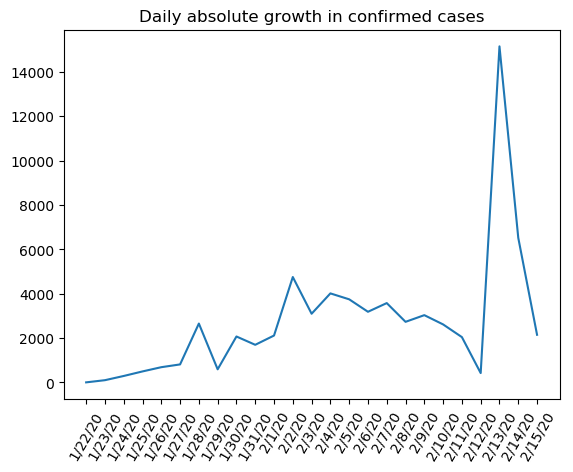

In [137]:
plt.plot(dates_confirmed, daily_abs_change_confirmed_all)
plt.xticks(rotation=60)
#plt.legend(['Absolute growth in confirmed cases'])
plt.title("Daily absolute growth in confirmed cases")
plt.savefig("img/abs_growth_confirmed.png",bbox_inches='tight')

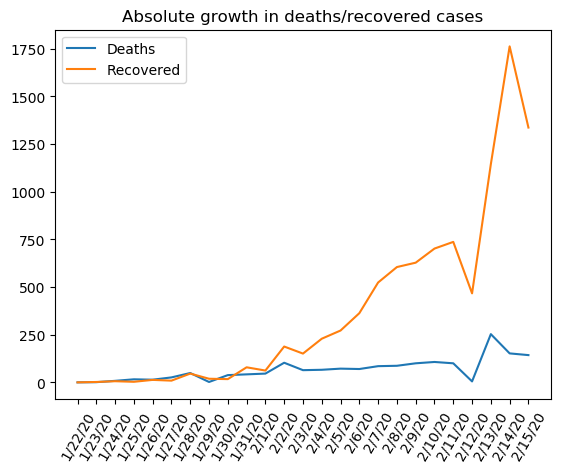

In [138]:
plt.plot(dates_confirmed, daily_abs_change_deaths_all, dates_confirmed,daily_abs_change_recovered_all)
plt.xticks(rotation=60)
plt.legend(['Deaths', 'Recovered'])
plt.title("Absolute growth in deaths/recovered cases")
plt.savefig("img/abs_growth_deaths_recovered.png",bbox_inches='tight')